In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../libs')
import data_lib
import plot_lib
import decision_lib
from sklearn import cluster, mixture
import validation_lib
import transform_lib

np.random.seed(200)

In [2]:
# print available data summary
_ = data_lib.explore_datasets(datafolder="../../Data",verbose=True)
print(data_lib.LABELS_LIST)

----------------------------------------------------------------------------------------------
-- The following 4 groups were found
-- They contain 40 datasets
-- The first printed entity is the key to the returned dictionary
-----------------------------------
Group: ../../Data/6P-wastewater-samples-labelled/droplet-level-data/RawData
wa-sa-D3, files: 14                     wa-sa-A3, files: 13                     wa-sa-C3, files: 13
wa-sa-A5, files: 13                     wa-sa-A2, files: 14                     wa-sa-A1, files: 13
wa-sa-A4, files: 13                     wa-sa-D2, files: 13                     wa-sa-B5, files: 13
wa-sa-B1, files: 13                     wa-sa-D4, files: 13                     wa-sa-C2, files: 13
wa-sa-C5, files: 13                     wa-sa-B2, files: 13                     wa-sa-D5, files: 14
wa-sa-B4, files: 13                     wa-sa-B3, files: 13                     wa-sa-C4, files: 13
wa-sa-D1, files: 13                     wa-sa-C1, files: 13   

### Get samples for negative control

In [3]:

# load the necessary datasetes
df_di = data_lib.load_dataset(None, [
    "po-di-se-2-A4", "po-di-se-2-B1", "po-di-se-2-C1", "po-di-se-2-C4",
    "po-di-se-2-D1", "po-di-se-2-D4", "po-di-se-2-A1", "po-di-se-2-B4",

    "po-di-se-1-D4", "po-di-se-1-D1", "po-di-se-1-B4", "po-di-se-1-A4",
    "po-di-se-1-B1", "po-di-se-1-C4", "po-di-se-1-A1", "po-di-se-1-C1",

    "po-di-se-B8", "po-di-se-D8", "po-di-se-A8", "po-di-se-C8",
                                     ], 
                              datafolder="../../Data")


df_negative_control = data_lib.load_dataset([],[
    "po-di-se-1-D1", "po-di-se-1-D4",
    "po-di-se-2-D1", "po-di-se-2-D4",
    "po-di-se-D8",
                                                ], 
                                            datafolder="../../Data")
# Everything is positive contol
df_positive_control = df_di.iloc[:,:6]

# convert to numpy
np_di = df_di.to_numpy(copy=True)[:,:6]
np_negative_control = df_negative_control.to_numpy()

In [4]:
# fix clustering algorithm
prediction_axis = ['SARS-N2_POS','SARS-N1_POS','IBV-M_POS','RSV-N_POS','IAV-M_POS','MHV_POS']
#cluster_engine = cluster.DBSCAN(eps=700, n_jobs=4, min_samples=6, leaf_size=5)
whitening_engine = transform_lib.WhitenTransformer()
num_cluster = int(2**len(prediction_axis) * 1.6)
cluster_engine = cluster.KMeans(n_clusters=num_cluster, n_init='auto')
#cluster_engine = mixture.GaussianMixture(n_components=100)
decision = decision_lib.ClusterHierarchyMeanClassifier(
                                     negative_control=np_negative_control,
                                     cluster_algorithm=cluster_engine,
                                     whitening_transformer=whitening_engine,
                                     eps=0.21,
                                     contamination=0.004,
                                     prediction_axis=prediction_axis,
                                     )
df_decision = decision.predict(np_di)

## Plot the predictions

- Black = True negative prediction
- Green = True positive prediciton
- Purple = False negative
- Red = False positive
- yellow = outlier

#### Plot for all diseases predictions against ground truth

Firs plot is in the decorrelated coordinates, whereas the second is in original coordinates

Outlier rate: 0.0011127094783175342, n_outlier: 543

Total error rate: 0.0004513237119323835
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.000185     0.000851   0.000698    0.00057   0.000191 0.000213

Precision (TP / (TP + FP)): 0.9981747477309232
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.998728     0.995599   0.996535   0.999211     0.9996 0.999149

Recall / TPR (TP / (TP + FN)): 0.9967575822691552
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999027     0.994373   0.995616   0.995035   0.998336 0.998395

Specificity / TNR (TN / (TN + FP)): 0.9998217048618644
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999886     0.999592   0.999662   0.999913   0.999959 0.999919

Accuracy ((TP + TN) / (P + N)): 0.9995486762880677
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999815     0.999149   0.999302    0.99943   0.999809 0.999787

F1 (2 * (precision 

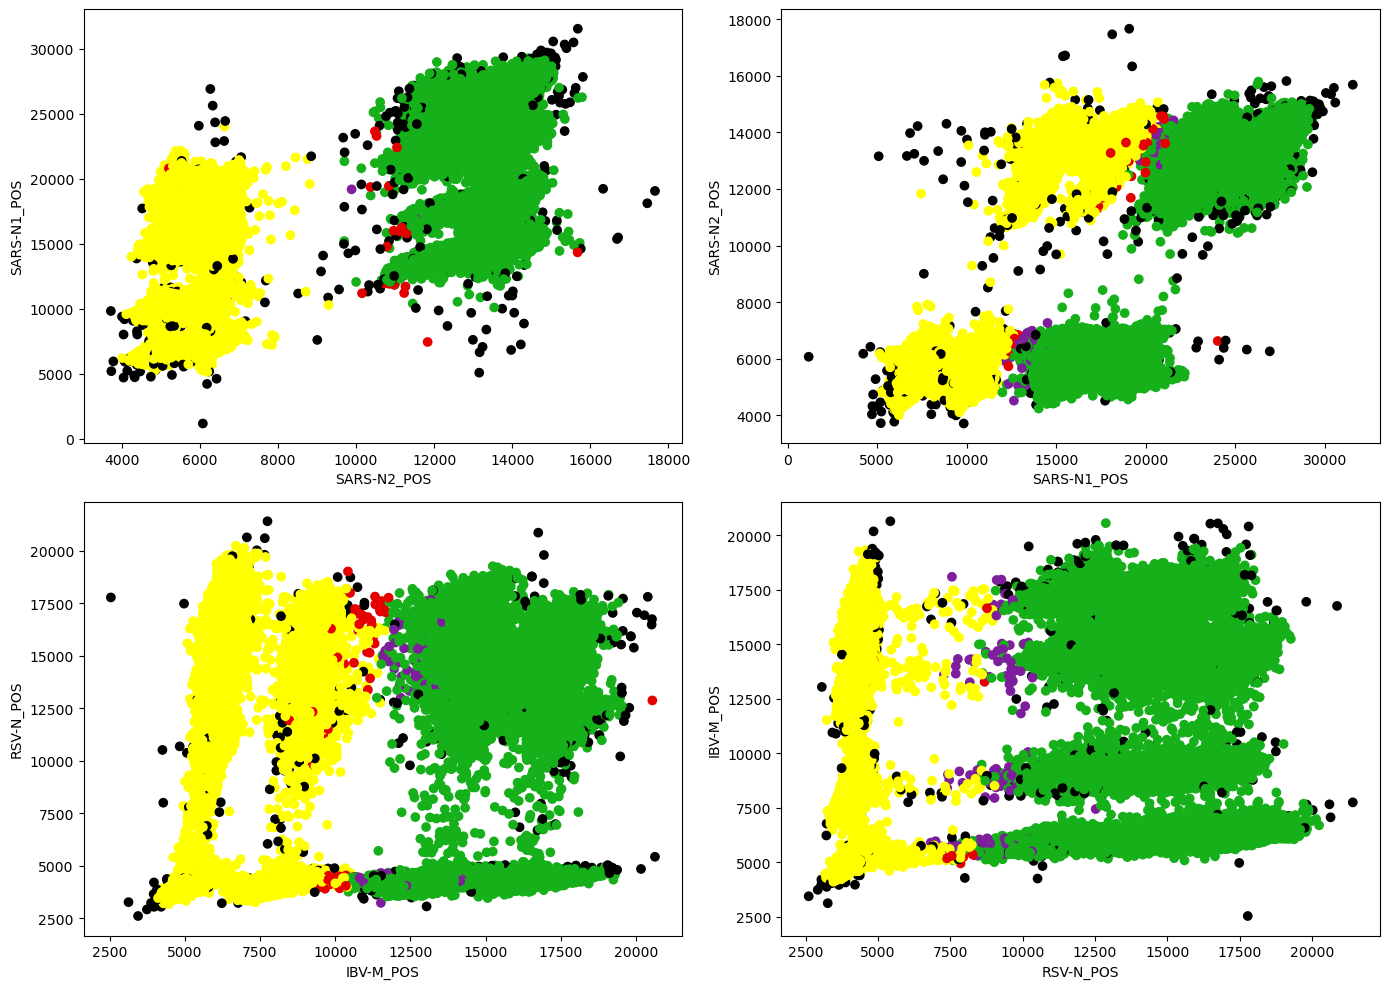

In [6]:

df_data_points = pd.DataFrame(data=decision.X, columns=prediction_axis) 
df_predictions = df_decision
df_ground_trouth = df_di
selected_pairs = [
                ('SARS-N2_POS','SARS-N1_POS'),
                ('SARS-N1_POS','SARS-N2_POS'),
                ('IBV-M_POS','RSV-N_POS'),
                ('RSV-N_POS','IBV-M_POS')#,
                #('IAV-M_POS','MHV_POS'),
                #('MHV_POS','IAV-M_POS'),
                ]
mask = decision.No_neg_mask

validation_lib.validate_labels(df_di, df_decision)

plot_lib.plot_pairwise_selection(
        df_data_points,
        df_predictions,
        df_ground_trouth,
        selected_pairs,
        n_cols=2,
        mask=mask,
        )

### Error inspection

print only cluster with missclassifications

ic| cluster: -1, dim: 'IAV-M_POS', n_cluster - n_true: 236


ic| cluster: 98, dim: 'IAV-M_POS', n_cluster - n_true: 1
ic| cluster: 99, dim: 'IAV-M_POS', n_cluster - n_true: 5
ic| cluster: -1, dim: 'MHV_POS', n_cluster - n_true: 226
ic| cluster: 98, dim: 'MHV_POS', n_cluster - n_true: 34
ic| cluster: 99, dim: 'MHV_POS', n_cluster - n_true: 28
ic| cluster: -1, dim: 'SARS-N1_POS', n_cluster - n_true: 295
ic| cluster: 10, dim: 'SARS-N1_POS', n_cluster - n_true: 11
ic| cluster: 12, dim: 'SARS-N1_POS', n_cluster - n_true: 7
ic| cluster: 16, dim: 'SARS-N1_POS', n_cluster - n_true: 12
ic| cluster: 70, dim: 'SARS-N1_POS', n_cluster - n_true: 9
ic| cluster: 82, dim: 'SARS-N1_POS', n_cluster - n_true: 80
ic| cluster: 83, dim: 'SARS-N1_POS', n_cluster - n_true: 5
ic| cluster: 93, dim: 'SARS-N1_POS', n_cluster - n_true: 6
ic| cluster: 98, dim: 'SARS-N1_POS', n_cluster - n_true: 29
ic| cluster: 99, dim: 'SARS-N1_POS', n_cluster - n_true: 15
ic| cluster: -1, dim: 'SARS-N2_POS', n_cluster - n_true: 240
ic| cluster: 82, dim: 'SARS-N2_POS', n_cluster - n_true: 88

(Partially) falsely classified clusters [-1  4 10 12 16 59 62 65 70 80 82 83 86 91 93 95 98 99]


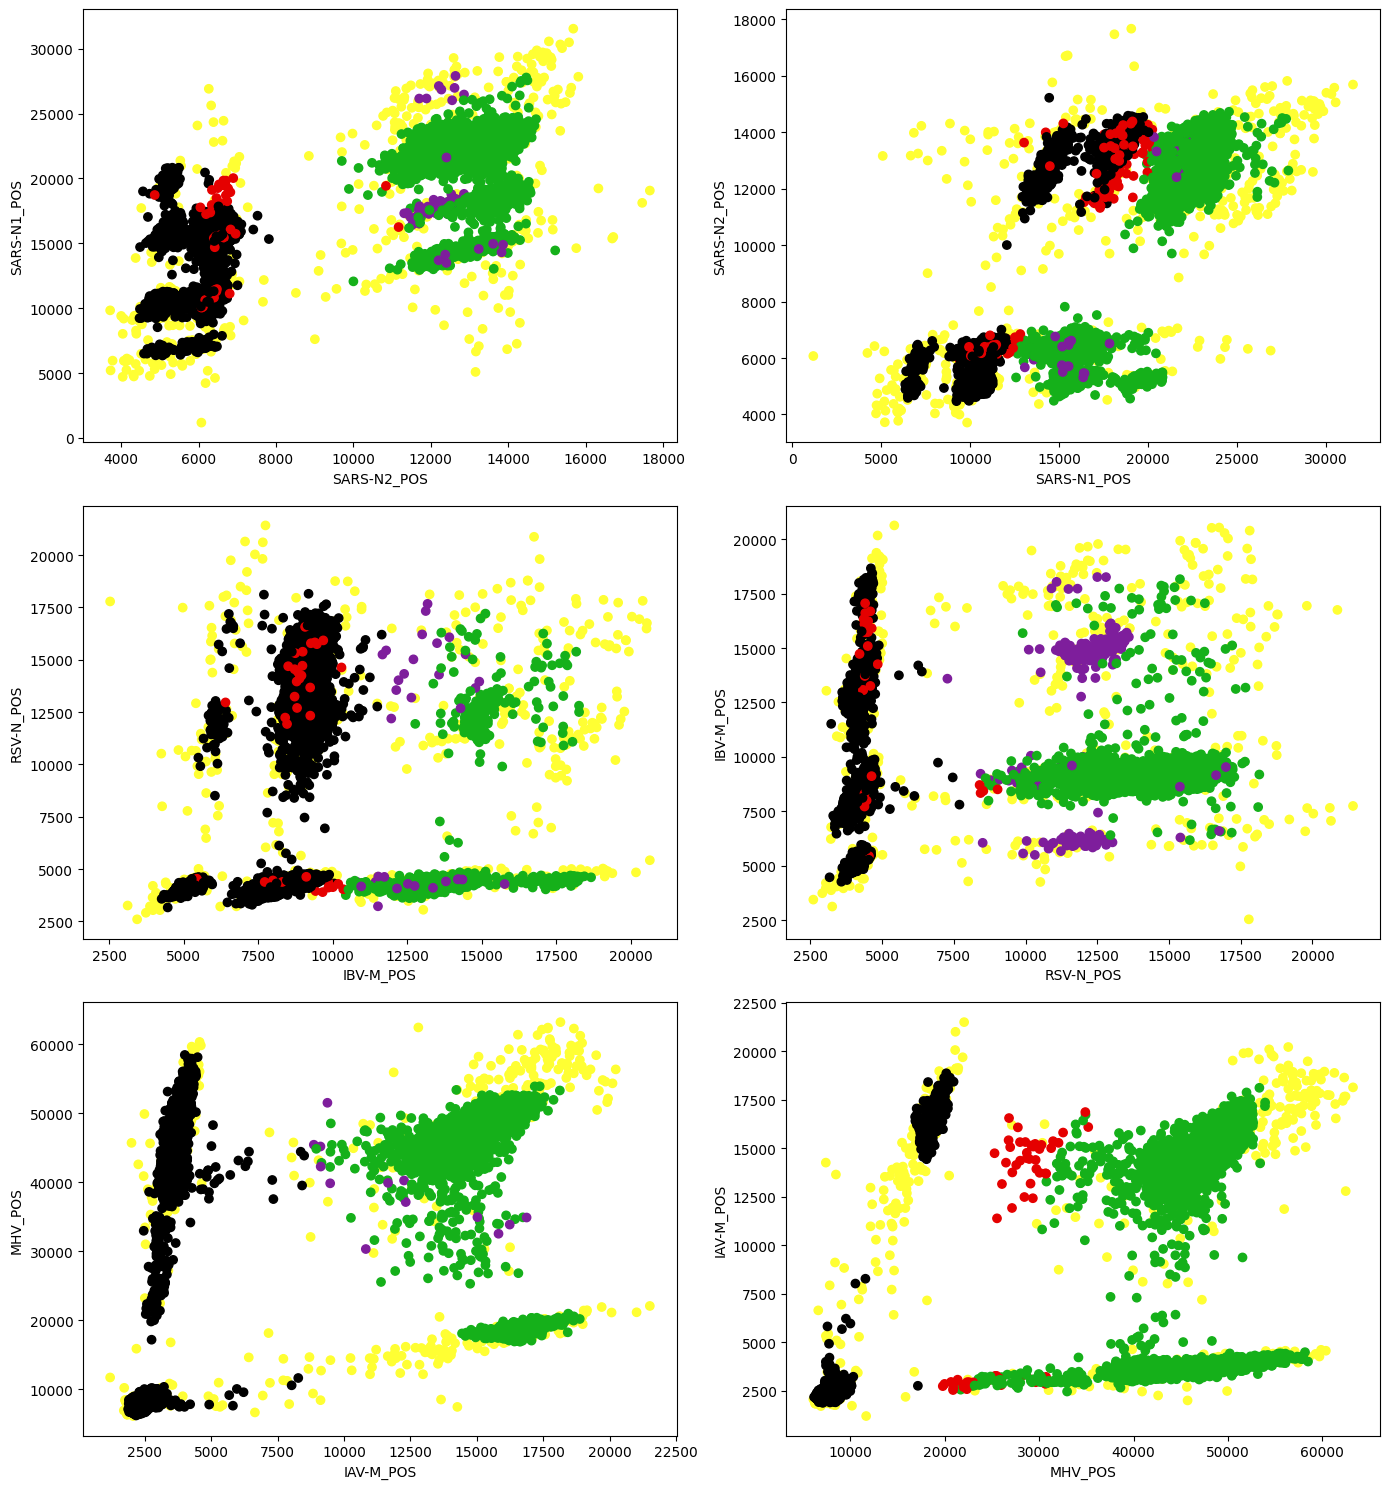

In [6]:
diseases = ["IAV-M_POS", "MHV_POS", "SARS-N1_POS", "SARS-N2_POS", "IBV-M_POS", "RSV-N_POS"]
false_clusters = validation_lib.get_false_clusters(clusters=decision.cluster_dict,
                                  df_true_labels=df_ground_trouth,
                                  df_predictions=df_predictions,
                                  disease=diseases,
                                  threshold=0.99)
df_false_data, df_false_predictions, df_false_ground_truth = validation_lib.get_false_cluster_for_plotting(df_data_points=df_data_points,
                                                                                                           df_predictions=df_predictions,
                                                                                                           df_ground_truth=df_ground_trouth,
                                                                                                           clusters=decision.cluster_dict,
                                                                                                           false_clusters=false_clusters)
print(f"(Partially) falsely classified clusters {false_clusters}")
plot_lib.plot_pairwise_selection(data_points=df_false_data, selected_pairs=selected_pairs, predictions=df_false_predictions, ground_trouth=df_false_ground_truth)